#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite difference methods for transient PDE

## Method of Lines

Our method for solving time-dependent problems will be to discretize in space first, resulting in a system of ordinary differential equations

$$ M \dot u = f(u) $$

where the "mass matrix" $M$ might be diagonal and $f(u)$ represents a spatial discretization that has the form $f(u) = A u$ for linear problems.

### Second Order Equations

A second order system such as

$$ \ddot u = f(t, u, \dot u) $$

may always be converted to a first order system by introducing a new variable

$$ \begin{bmatrix} u_0 \\ u_1 \end{bmatrix}' = \begin{bmatrix} u_1 \\ f(t, u_0, u_1) \end{bmatrix} . $$
Therefore, without loss of generality, we will focus on first order systems.

### Implicit formulations

We have chosen the representation $M \dot u = f(t,u)$, but it is more general to write $h(t,u,\dot u) = 0$.
If $\partial h/\partial \dot u$ is singular, then this describes a *differential algebraic equation* (DAE).  General DAE are more challenging to solve and beyond the scope of this course, though we will allow a special case.  We will consider cases in which the mass matrix $M$ is singular due to zero rows -- this is sometimes convenient to enforce boundary conditions and results in an "index 1" DAE.

## Linear Equations

If $f(u) = A u$ is a linear function of $u$ then we have a linear ODE
$$ \dot u = A(t) u + \text{source}(t) . $$
If $A(t)$ is independent of $t$ and $\text{source}(t) = 0$ then we have a linear, constant, autonomous ODE.

#### Non-autonomous ODE

Our ODE is "non-autonomous" if $\text{source}(t) \ne 0$.  In that case, we can augment our system with a new independent variable $u_s$ and equation $u_s = 1$, then substitute $t = u_s$ to arrive at an equivalent autonomous formulation.  The augmented equation will be integrated exactly using every method that we will consider.  So there is no loss of generality by assuming that the system is autonomous, though many production ODE solvers will have direct support for non-autonomous systems.

### Exponentials

When $u$ is a scalar then $A = \lambda$ is a scalar and the solution is
$$ u(t) = u(0) e^{\lambda t} . $$

#### Question
What qualitative dynamics does this imply for
* $\lambda > 0$?
* $\lambda < 0$?
* $\lambda$ imaginary?

#### Question
* What if $A$ is diagonal?
* What if $A = X \Lambda X^{-1}$?

#### Matrix exponential
The general solution can be written in terms of the matrix exponential.
$$ u(t) = e^{At} u(0) . $$
The matrix exponential is defined by its Taylor series
$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are [many practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

### Forward Euler Method

The simplest method for solving $\dot u(t) = f(t,u)$ is
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$

Let's try this on a scalar problem

$$ \dot u = -k (u - \cos t) $$

where $k$ is a parameter controlling the rate at which the solution $u(t)$ is pulled toward the curve $\cos t$.

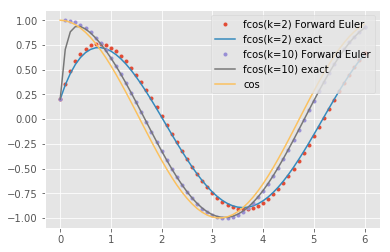

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def ode_euler(f, u0, tfinal=1, h=0.1):
    u = numpy.array(u0)
    t = 0
    thist = [t]
    uhist = [u0]
    while t < tfinal:
        h = min(h, tfinal - t)
        u += h * f(t, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.array(thist), numpy.array(uhist)

tests = []

class fcos:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'fcos(k={:d})'.format(self.k)
    def f(self, t, u):
        return -self.k * (u - numpy.cos(t))
    def u(self, t, u0):
        k2p1 = self.k**2+1
        return (u0 - self.k**2/k2p1) * numpy.exp(-self.k*t) + self.k*(numpy.sin(t) + self.k*numpy.cos(t))/k2p1

tests.append(fcos(k=2))
tests.append(fcos(k=10))

u0 = numpy.array([.2])
pyplot.figure()
for test in tests:
    thist, uhist = ode_euler(test.f, u0, h=.1, tfinal=6)
    pyplot.plot(thist, uhist, '.', label=repr(test)+' Forward Euler')
    pyplot.plot(thist, test.u(thist, u0), label=repr(test)+' exact')
pyplot.plot(thist, numpy.cos(thist), label='cos')
pyplot.legend(loc='upper right');

#### Questions
* What happens when $h$ is increased?
* What if $k$ is increased?

#### Example: Linear system

Now we consider linear systems

$$ \dot u = A u $$

which have an exact solution $u(t) = e^{At} u(0)$ in terms of the matrix exponential.

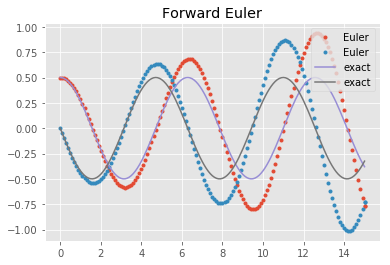

In [2]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X.dot(numpy.diag(numpy.exp(L))).dot(numpy.linalg.inv(X))

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A.dot(u)
    def u(self, t, u0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real(expm(self.A*s).dot(u0)) for s in t]

test = linear(numpy.array([[0, 1],[-1, 0]]))
u0 = numpy.array([.5, 0])
thist, uhist = ode_euler(test.f, u0, h=.1, tfinal=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Euler')
pyplot.plot(thist, test.u(thist, u0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Forward Euler');

#### Questions
* Does shrinking $h$ make this more accurate?
* What if `tfinal` is extended?
* What are the eigenvalues of $A$?

### Implicit methods
Recall that forward Euler is the step
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde u(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde u(h) = u(0) + h f(h, \tilde u(h)) . $$
This is a (generally) nonlinear equation for $\tilde u(h)$.

We'll discuss the nonlinear case later and consider the linear case $f(t,u) = A u$, for which backward Euler reduces to

$$ \tilde u(h) = u(0) + h A \tilde u(h) $$

or

$$ (I - h A) u(h) = u(0) . $$
This requires solving a linear system involving both $h$ and $A$.  Depending on the problem, this may be significantly more expensive than merely multiplying by $A$.

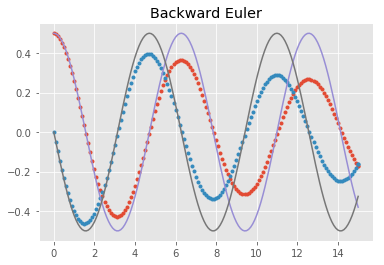

In [3]:
def ode_beuler_linear(A, u0, tfinal=1, h=0.1):
    u = numpy.array(u0)
    t = 0
    thist = [t]
    uhist = [u0]
    while t < tfinal:
        h = min(h, tfinal - t)
        # Solve (I - hA)u = u(0)
        u = numpy.linalg.solve(numpy.eye(len(u)) - h*A, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.array(thist), numpy.array(uhist)

thist, uhist = ode_beuler_linear(test.A, u0, h=.1, tfinal=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.')
pyplot.plot(thist, test.u(thist, u0))
pyplot.title('Backward Euler');

### Midpoint Method

What if instead of evaluating the function at the end of the time step, we evaluated in the middle of the time step using the average of the endpoint values.

$$ \tilde u(h) = u(0) + h f\left(\frac h 2, \frac{\tilde u(h) + u(0)}{2} \right) $$

For the linear problem, this reduces to

$$ \Big(I - \frac h 2 A \Big) u(h) = \Big(I + \frac h 2 A\Big) u(0) .$$

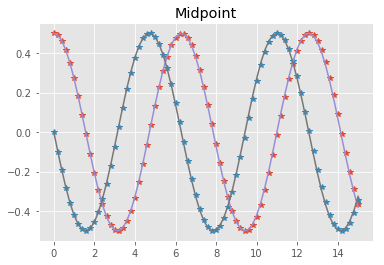

In [4]:
def ode_midpoint_linear(A, u0, tfinal=1, h=0.1):
    u = u0.copy()
    t = 0
    thist = [t]
    uhist = [u0]
    I = numpy.eye(len(u))
    while t < tfinal:
        h = min(h, tfinal - t)
        u = numpy.linalg.solve(I - .5*h*A, (I + .5*h*A).dot(u))
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.array(thist), numpy.array(uhist)

thist, uhist = ode_midpoint_linear(test.A, u0, h=.2, tfinal=15)
pyplot.figure()
pyplot.plot(thist, uhist, '*')
pyplot.plot(thist, test.u(thist, u0))
pyplot.title('Midpoint');

### Linear Stability Analysis

Why did forward Euler diverge while backward Euler decayed and Midpoint is apparently quite accurate for long time periods?  We can answer this by considering the test equation
$$ \dot u = \lambda u $$
and applying each method to construct
$$ u(h) = R(h\lambda) u(0) $$
where $R(z)$ is called the **stability function**.

$$\begin{align} R(z) &= 1+z & \text{Forward Euler} \\
R(z) &= \frac{1}{1-z} & \text{Backward Euler} \\
R(z) &= \frac{1+z/2}{1-z/2} & \text{Midpoint}
\end{align}$$

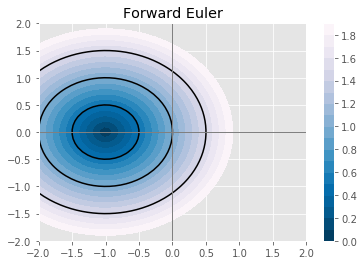

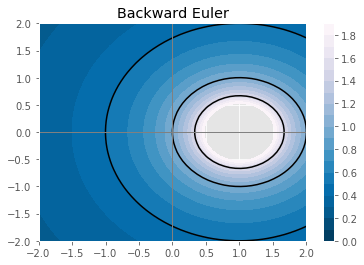

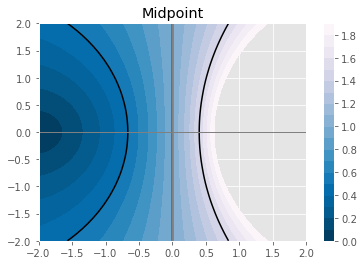

In [5]:
def plot_stability(x, y, Rz, label):
    pyplot.figure()
    C = pyplot.contourf(xx, yy, numpy.abs(Rz), numpy.arange(0,2,.1), cmap=pyplot.cm.PuBu_r)
    pyplot.colorbar(C)
    pyplot.axvline(x=0, linewidth=1, color='grey')
    pyplot.axhline(y=0, linewidth=1, color='grey')
    pyplot.contour(xx, yy, numpy.abs(Rz), numpy.arange(0,2,.5), colors='k')
    pyplot.title(label)

x = numpy.linspace(-2,2)
xx, yy = numpy.meshgrid(x, x)
zz = xx + 1j*yy
Rlist = [('Forward Euler', 1+zz),
        ('Backward Euler', 1/(1-zz)),
        ('Midpoint', (1+zz/2)/(1-zz/2))]
for Rlabel, R in Rlist:
    plot_stability(xx, yy, R, Rlabel)

## $\theta$ method

The above methods are all special cases of the $\theta$ method

$$ \tilde u(h) = u(0) + h f\left(\theta h, \theta\tilde u(h) + (1-\theta)u(0) \right) $$

which, for linear problems, is solved as

$$ (I - h \theta A) u(h) = \Big(I + h (1-\theta) A \Big) u(0) . $$

$\theta=0$ is explicit Euler, $\theta=1$ is implicit Euler, and $\theta=1/2$ is the midpoint rule.
The stability function is
$$ R(z) = \frac{1 + (1-\theta)z}{1 - \theta z}. $$

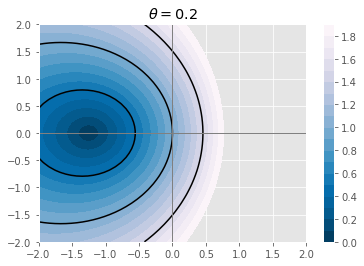

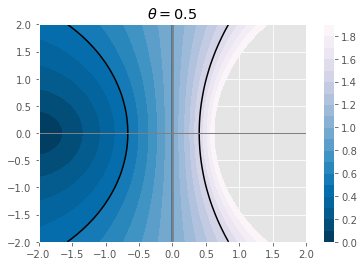

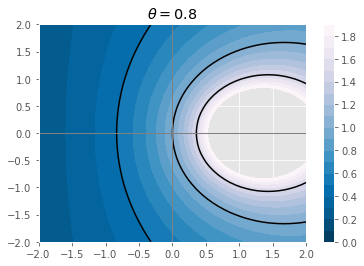

In [6]:
for theta in [.2, .5, .8]:
    plot_stability(xx, yy, (1 + (1-theta)*zz)/(1 - theta*zz), '$\\theta={:3.1f}$'.format(theta))

We will generalize slightly to allow solution of a linear differential algebraic equation

$$ M \dot u = A u + f(t,x) $$

where $M$ is (for now) a diagonal matrix that has zero rows at boundary conditions.  With this generalization, the $\theta$ method becomes

$$ (M - h \theta A) u(h) = \Big(M + h (1-\theta) A \Big) u(0) + h f(h\theta, x) . $$

We will assume that $M$ is nonsingular if $\theta=0$.

In [7]:
def dae_theta_linear(M, A, u0, rhsfunc, bcs=[], tfinal=1, h=0.1, theta=.5):
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        rhs = (M + (1-theta)*h*A).dot(u) + h*rhsfunc(t+theta*h)
        for i, f in bcs:
            rhs[i] = theta*h*f(t+theta*h, x[i])
        u = numpy.linalg.solve(M - theta*h*A, rhs)
        t = tnext
        hist.append((t, u.copy()))
    return hist

### Stiff decay to cosine

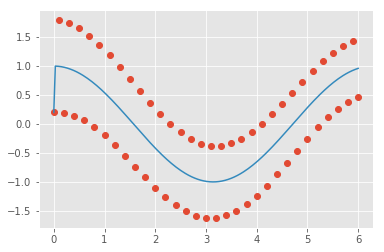

In [31]:
test = fcos(k=5000)
u0 = numpy.array([.2])
hist = dae_theta_linear(numpy.eye(1), -test.k, u0,
                        lambda t: test.k*numpy.cos(t),
                        h=.1, tfinal=6, theta=.5)
hist = numpy.array(hist)
pyplot.plot(hist[:,0], hist[:,1], 'o')
tt = numpy.linspace(0, 6, 200)
pyplot.plot(tt, test.u(tt,u0));

#### Observations

* $\theta=1$ is robust
* $\theta=1/2$ gets correct long-term behavior, but has oscillations at early times
* $\theta < 1/2$ allows oscillations to grow

#### Convergence plots

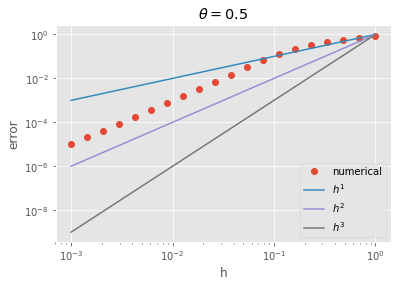

In [9]:
def mms_error(h, theta):
    test = fcos(k=20)
    u0 = numpy.array([.2])
    hist = dae_theta_linear(numpy.eye(1), -test.k, u0,
                            lambda t: test.k*numpy.cos(t), h=h, tfinal=3,
                            theta=theta)
    hist = numpy.array(hist)
    return numpy.linalg.norm(hist[:,1] - test.u(hist[:,0], u0), numpy.inf)

theta = .5
hs = numpy.logspace(-3, 0, 20)
errors = [mms_error(h, theta) for h in hs]
pyplot.loglog(hs, errors, 'o', label='numerical')
for p in range(1,4):
    pyplot.loglog(hs, hs**p, label='$h^{%d}$'%p)
pyplot.xlabel('h')
pyplot.ylabel('error')
pyplot.legend(loc='lower right')
pyplot.title('$\\theta=%3.1f$' % theta);

#### Observations

* $\theta=1$ is robust with large time steps (or large $k$).
* $\theta=1$ absolute error increases as initial transient is resolved.
* Only $\theta=1/2$ is second order accurate.
* $\theta < 1/2$ is unstable (diverges) for large time steps.

### Definition: $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

### Definition: $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.

### Oscillatory linear system

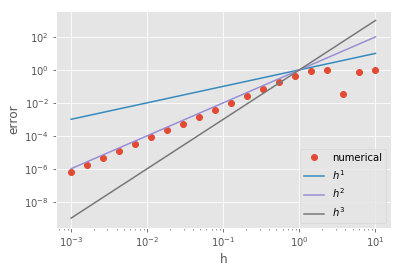

In [35]:
def mms_error(h):
    test = linear(numpy.array([[0, 1],[-1, 0]]))
    u0 = numpy.array([.5, 0])
    hist = dae_theta_linear(numpy.eye(2), test.A, u0, lambda t: 0, h=h, tfinal=15,
                            theta=.5)
    return numpy.linalg.norm(test.u(hist[-1][0], u0) - hist[-1][1])

hs = numpy.logspace(-3, 1, 20)
errors = [mms_error(h) for h in hs]
pyplot.loglog(hs, errors, 'o', label='numerical')
for p in range(1,4):
    pyplot.loglog(hs, hs**p, label='$h^{%d}$'%p)
pyplot.xlabel('h')
pyplot.ylabel('error')
pyplot.legend(loc='lower right');

#### Observations

* If $h$ is too large, we don't resolve the solution.
* $\theta=1/2$ is the only second order method and is always more accurate than other choices, even with large time steps.

## Transient PDE

### Diffusion (heat equation)

Let's first consider diffusion of a quantity $u(t,x)$

$$ \dot u(t,x) - u''(t,x) = f(t,x) \qquad t > 0, -1 < x < 1 \\
u(0,x) = g(x) \qquad u(t,-1) = h_L(t) \qquad u'(t,1) = h_R(t) .$$

Let's use a Chebyshev discretization in space.

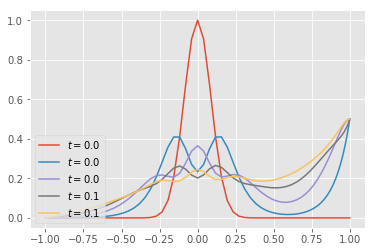

In [11]:
%run fdtools.py  # define cosspace, vander_chebyshev, and chebeval

def diffusion_cheb(n, left, right):
    """Solve the diffusion PDE on (-1,1) using n elements with rhsfunc(x) forcing.
    The left and right boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)"""
    x = cosspace(-1, 1, n+1)  # n+1 points is n "elements"
    T = chebeval(x)
    L = -T[2]
    bcs = []
    for i,deriv,func in [(0, *left), (-1, *right)]:
        L[i] = T[deriv][i]
        bcs.append((i, func))
    M = numpy.eye(n+1)
    M[[0,-1]] = 0
    return x, M, -L.dot(numpy.linalg.inv(T[0])), bcs

x, M, A, bcs = diffusion_cheb(80, (0, lambda t,x: 0*x), (0, lambda t,x: 0*x+.5))
hist = dae_theta_linear(M, A, numpy.exp(-(x*8)**2), lambda t: 0*x, bcs,
                        h=.02, theta=.5)
for t, u in hist[:5]:
    pyplot.plot(x, u, label='$t={:3.1f}$'.format(t))
pyplot.legend(loc='lower left');

#### Observations
* Sharp central spike is diffused very quickly.
* Artifacts with $\theta < 1$.

#### Manufactured solution

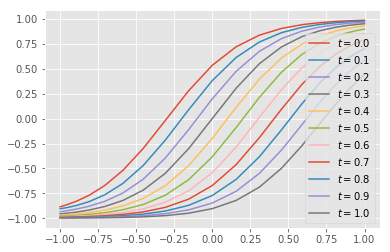

In [12]:
class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, t, x):
        return numpy.tanh(self.k*(x - t - self.x0))
    def u_x(self, t, x):
        return self.k * numpy.cosh(self.k*(x - t - self.x0))**(-2)
    def u_t(self, t, x):
        return -self.u_x(t, x)
    def u_xx(self, t, x):
        return -2 * self.k**2 * numpy.tanh(self.k*(x - t - self.x0)) * numpy.cosh(self.k*(x - t - self.x0))**(-2)
    def heatrhs(self, t, x):
        return self.u_t(t,x) - self.u_xx(t,x)

ex = exact_tanh(2, -.3)
x, M, A, bcs = diffusion_cheb(20, (0, ex.u), (1, ex.u_x))
hist = dae_theta_linear(M, A, ex.u(0,x), lambda t: ex.heatrhs(t,x), bcs)
for t, u in hist:
    pyplot.plot(x, u, label='$t={:3.1f}$'.format(t))
pyplot.legend(loc='lower right');

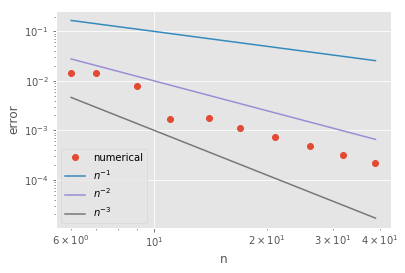

In [13]:
def mms_error(n):
    x, M, A, bcs = diffusion_cheb(n, (0, ex.u), (1, ex.u_x))
    hist = dae_theta_linear(M, A, ex.u(0,x),
                            lambda t: ex.heatrhs(t,x), bcs, h=1/n**2, theta=1)
    return numpy.linalg.norm(hist[-1][1] - ex.u(hist[-1][0], x),
                             numpy.inf)

ns = numpy.logspace(.8, 1.6, 10).astype(int)
errors = [mms_error(n) for n in ns]
pyplot.loglog(ns, errors, 'o', label='numerical')
for p in range(1,4):
    pyplot.loglog(ns, 1/ns**(p), label='$n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')
pyplot.legend(loc='lower left');

#### Observations

* Errors are limited by time (not spatial) discretization error.  This is a result of using the (spectrally accurate) Chebyshev method in space.
* $\theta=1$ is more accurate than $\theta = 1/2$, despite the latter being second order accurate in time.  This is analogous to the stiff relaxation to cosine test.

#### Largest eigenvalues

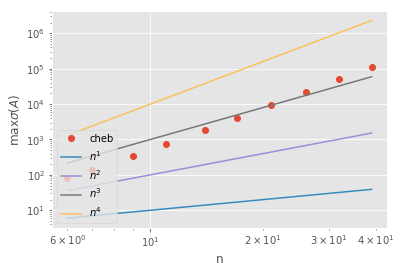

In [14]:
def maxeig(n):
    x, M, A, bcs = diffusion_cheb(n, (0, ex.u), (1, ex.u_x))
    lam = numpy.linalg.eigvals(-A)
    return max(lam)

pyplot.loglog(ns, [maxeig(n) for n in ns], 'o', label='cheb')
for p in range(1,5):
    pyplot.loglog(ns, ns**(p), label='$n^{%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('$\max \sigma(A)$')
pyplot.legend(loc='lower left');

### Finite difference method

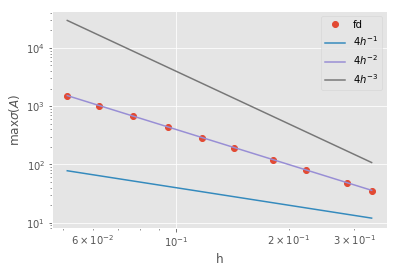

In [15]:
def maxeig_fd(n):
    dx = 2/n
    A = 1/dx**2 * (2 * numpy.eye(n+1) - numpy.eye(n+1, k=1) - numpy.eye(n+1, k=-1))
    return max(numpy.linalg.eigvals(A))

pyplot.loglog(2/ns, [maxeig_fd(n) for n in ns], 'o', label='fd')
for p in range(1,4):
    pyplot.loglog(2/ns, 4*(2/ns)**(-p), label='$4 h^{-%d}$'%p)
pyplot.xlabel('h')
pyplot.ylabel('$\max \sigma(A)$')
pyplot.legend(loc='upper right');

#### Question: max explicit Euler time step

Express the maximum stable time step $\Delta t$ using explicit Euler in terms of the grid spacing $\Delta x$.

## Hyperbolic (wave) equations

The simplest hyperbolic equation is linear advection

$$ \dot u(t,x) + c u'(t,x) = f(t,x) $$

where $c$ is the wave speed and $f$ is a source term.  In the homogenous ($f = 0$) case, the solution is given by characteristics

$$ u(t,x) = u(0, x - ct) . $$

This PDE also requires boundary conditions, but as a first-order equation, we can only enforce boundary conditions at one boundary.  It turns out that this needs to be the _inflow_ boundary, so if $c > 0$, that is the left boundary condition $u(t, -1) = g(t)$.  We can solve this system using Chebyshev methods.

5734.3899608827378

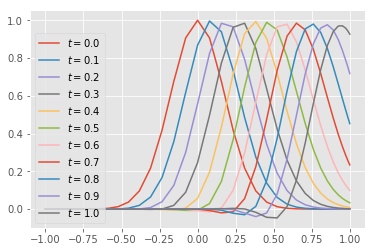

In [64]:
def advection_cheb(n, c, left=(None,None), right=(None,None)):
    """Discretize the advection PDE on (-1,1) using n elements with rhsfunc(x) forcing.
    The left boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)"""
    x = cosspace(-1, 1, n+1)  # n+1 points is n "elements"
    T = chebeval(x)
    A = -c*T[1]
    M = numpy.eye(n+1)
    bcs = []
    for i,deriv,func in [(0, *left), (-1, *right)]:
        if deriv is None: continue
        A[i] = T[deriv][i]
        M[i] = 0
        bcs.append((i, func))
    return x, M, A @ numpy.linalg.inv(T[0]), bcs

x, M, A, bcs = advection_cheb(40, 1, left=(0, lambda t,x: 0*x))
hist = dae_theta_linear(M, A, numpy.exp(-(x*4)**2), lambda t: 0*x, bcs,
                        h=.1, theta=1/2)
for t, u in hist[::len(hist)//10]:
    pyplot.plot(x, u, label='$t={:3.1f}$'.format(t))
pyplot.legend(loc='lower left')
numpy.linalg.cond(A)

[  1.00000000e+00   9.71445147e-17  -1.11022302e-16   1.73472348e-17
   4.85722573e-17]


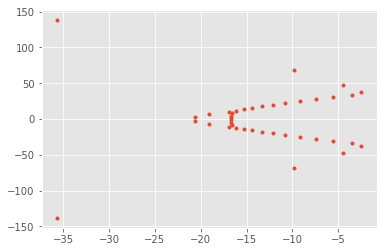

In [65]:
lam = numpy.linalg.eigvals(A[1:,1:])
print(A[0,:5])
pyplot.plot(lam.real, lam.imag, '.');

#### Observations
* $\theta > 1/2$ causes decay in amplitude
* $\theta < 1/2$ causes growth -- unstable
* An undershoot develops behind the traveling wave and increasing resolution doesn't make it go away
* We need an *upwind* boundary condition, otherwise the system is unstable
* Only Dirichlet inflow conditions are appropriate -- Neumann conditions produce a singular matrix

### Finite difference

stencil [  0.   0.  20. -20.   0.   0.   0.]
cond 260.145200172


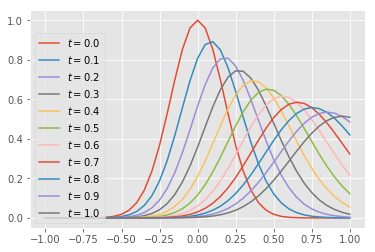

In [71]:
def advection_fd(n, c, stencil=2, bias=0, left=None, right=None):
    x = numpy.linspace(-1, 1, n+1)
    A = numpy.zeros((n+1,n+1))
    for i in range(n+1):
        sleft = max(0, i - stencil//2 + bias)
        sleft = min(sleft, n+1 - stencil)
        A[i,sleft:sleft+stencil] = -c*fdstencil(x[i], x[sleft:sleft+stencil])[1]
    M = numpy.eye(n+1)
    bcs = []
    for i, func in [(0, left), (-1, right)]:
        if func is None: continue
        A[i] = 0
        A[i,i] = 1
        M[i] = 0
        bcs.append((i, func))
    return x, M, A, bcs

x, M, A, bcs = advection_fd(40, c=1, stencil=2, bias=0, left=lambda t,x: 0*x)
hist = dae_theta_linear(M, A, numpy.exp(-(x*4)**2), lambda t: 0*x, bcs,
                        h=2/(len(x)-1), theta=.9)
for t, u in hist[::len(hist)//10]:
    pyplot.plot(x, u, label='$t={:3.1f}$'.format(t))
pyplot.legend(loc='lower left')
print('stencil', A[3,:7])
print('cond', numpy.linalg.cond(A))

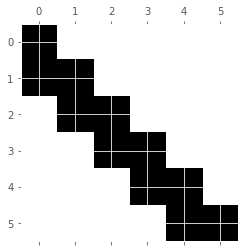

In [19]:
lam = numpy.linalg.eigvals(A[1:,1:])
#pyplot.plot(lam.real, lam.imag, '.')
pyplot.spy(A[:6,:6])

#### Observations

* Centered methods have an undershoot behind the traveling wave
* Upwind biasing of the stencil tends to reduce artifacts, but only `stencil=2` removes undershoots
* Downwind biasing is usually unstable
* With upwinded `stencil=2`, we can use an explicit integrator, but the time step must satisfy
$$ c \Delta t < \Delta x $$
* The upwind methods are in general dissipative -- amplitude is lost even with very accurate time integration
* The higher order upwind methods always produce artifacts for sharp transitions

### Phase analysis

We can apply the advection differencing stencils to the test functions $$ \phi(x, \theta) = e^{i \theta x}$$ and compare to the exact derivative $$ \frac{d \phi}{d x} = i \theta \phi(x, \theta) . $$

[-0.25       -0.83333333  1.5        -0.5         0.08333333]


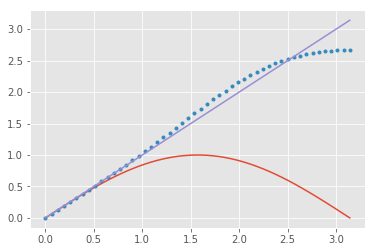

In [36]:
x = numpy.arange(-1, 3+1)
s1 = fdstencil(0, x)[1]
print(s1)
theta = numpy.linspace(0, numpy.pi)
phi = numpy.exp(1j*numpy.outer(x, theta))
pyplot.plot(theta, numpy.sin(theta))
pyplot.plot(theta, numpy.abs(s1.dot(phi)), '.')
pyplot.plot(theta, theta);

# Runge-Kutta methods

The methods we have considered thus far can all be expressed as Runge-Kutta methods, which are expressed in terms of $s$ "stage" equations (possibly coupled) and a completion formula.  For the ODE

$$ \dot u = f(t, u) $$

the Runge-Kutta method is

$$\begin{split}
Y_i = u(t) + h \sum_j a_{ij} f(t+c_j h, Y_j) \\
u(t+h) = u(t) + h \sum_j b_j f(t+c_j h, Y_j)
\end{split}$$

where $c$ is a vector of *abscissa*, $A$ is a table of coefficients, and $b$ is a vector of completion weights.
These coefficients are typically expressed in a Butcher Table
$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] . $$
We will see that, for consistency, the abscissa $c$ are always the row sums of $A$ and that $\sum_i b_i = 1$.

If the matrix $A$ is strictly lower triangular, then the method is **explicit** (does not require solving equations).  We have seen forward Euler

$$ \left[ \begin{array}{c|cc}
0 & 0 \\
\hline
& 1
\end{array} \right] ,$$
backward Euler
$$ \left[ \begin{array}{c|c}
1 & 1 \\
\hline
& 1
\end{array} \right] ,$$
and Midpoint
$$ \left[ \begin{array}{c|c}
\frac 1 2 & \frac 1 2 \\
\hline
& 1
\end{array} \right]. $$

Indeed, the $\theta$ method is
$$ \left[ \begin{array}{c|c}
\theta & \theta \\
\hline
& 1
\end{array} \right] $$
and an alternative "endpoint" variant of $\theta$ (a generalization of the trapezoid rule) is
$$ \left[ \begin{array}{c|cc}
0 & 0 & 0 \\
1 & 1-\theta & \theta \\
\hline
& 1-\theta & \theta
\end{array} \right]. $$

## Stability

To develop an algebraic expression for stability in terms of the Butcher Table, we consider the test equation

$$ \dot u = \lambda u $$

and apply the RK method to yield

$$ \begin{split} Y_i = u(0) + h \sum_j a_{ij} \lambda Y_j \\
u(h) = u(0) + h \sum_j b_j \lambda Y_j \end{split} $$

or, in matrix form,

$$ \begin{split} Y = \mathbb 1 u(0) + h \lambda A Y \\
u(h) = u(0) + h \lambda b^T Y \end{split} $$

where $\mathbb 1$ is a column vector of length $s$ consisting of all ones.
This reduces to
$$ u(h) = \underbrace{\Big( 1 + h\lambda b^T (I - h \lambda A)^{-1} \mathbb 1 \Big)}_{R(h\lambda)} u(0) . $$

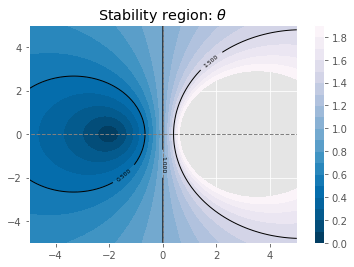

In [21]:
def Rstability(A, b, z):
    s = len(b)
    def R(z):
        return 1 + z*b.dot(numpy.linalg.solve(numpy.eye(s) - z*A, numpy.ones(s)))
    f = numpy.vectorize(R)
    return f(z)

def rk_butcher_theta(theta):
    A = numpy.array([[theta]])
    b = numpy.array([1])
    return A, b

def zmeshgrid(xlen=5, ylen=5):
    xx = numpy.linspace(-xlen, xlen, 100)
    yy = numpy.linspace(-ylen, ylen, 100)
    x, y = numpy.meshgrid(xx, yy)
    z = x + 1j*y
    return x, y, z

def plot_rkstability(A, b, label=''):
    from matplotlib import pyplot, ticker, cm, axis
    import numpy as np
    x, y, z = zmeshgrid()
    data = numpy.abs(Rstability(A, b, z))
    cs = pyplot.contourf(x, y, data, np.arange(0, 2, 0.1), cmap=cm.PuBu_r)
    cbar = pyplot.colorbar(cs)
    pyplot.axhline(y=0, xmin=-20.0, xmax=20.0, linewidth=1, linestyle='--', color='grey')
    pyplot.axvline(x=0, ymin=-20.0, ymax=20.0, linewidth=1, linestyle='--', color='grey')
    cs = pyplot.contour(x, y, data, np.arange(0, 2, 0.5), colors='k')
    pyplot.clabel(cs, fontsize=6)
    for c in cs.collections:
      pyplot.setp(c, linewidth=1)
    pyplot.title('Stability region' + (': ' + label if label else ''))

A, b = rk_butcher_theta(.5)
plot_rkstability(A, b, label='$\\theta$')

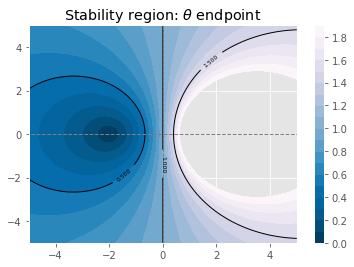

In [22]:
def rk_butcher_theta_endpoint(theta):
    A = numpy.array([[0, 0], [1-theta, theta]])
    b = numpy.array([1-theta, theta])
    return A, b

A, b = rk_butcher_theta_endpoint(.5)
plot_rkstability(A, b, label='$\\theta$ endpoint')

Evidently the endpoint variant of $\theta$ has the same stability function as the original (midpoint) variant that we've been using.  These methods are equivalent for linear problems, but different for nonlinear problems.

## Higher order explicit methods: Heun's and RK4

Explicit Euler steps can be combined to create more accurate methods.  One such example is Heun's method,
$$ \left[ \begin{array}{c|cc}
0 & 0 & 0 \\
1 & 1 & 0 \\
\hline
& \frac 1 2 & \frac 1 2
\end{array} \right]. $$

Another explicit method is the famous four-stage RK4,
$$ \left[ \begin{array}{c|cccc}
0 & 0 & 0 & 0 & 0 \\
\frac 1 2 & \frac 1 2 & 0 & 0 & 0 \\
\frac 1 2 & 0 & \frac 1 2 & 0 & 0 \\
1 & 0 & 0 & 1 & 0 \\
\hline
& \frac 1 6 & \frac 1 3 & \frac 1 3 & \frac 1 6
\end{array} \right] . $$

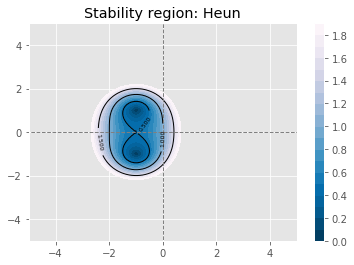

In [23]:
def rk_butcher_heun():
    A = numpy.array([[0, 0],[1,0]])
    b = numpy.array([.5, .5])
    return A, b

A, b = rk_butcher_heun()
plot_rkstability(A, b, label='Heun')

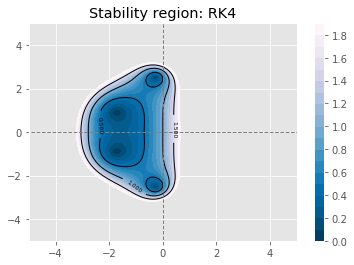

In [24]:
def rk_butcher_4():
    A = numpy.array([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]])
    b = numpy.array([1/6, 1/3, 1/3, 1/6])
    return A, b

A, b = rk_butcher_4()
plot_rkstability(A, b, label='RK4')

Finally a method with lots of stability along the imaginary axis.  Let's try it on some test problems.

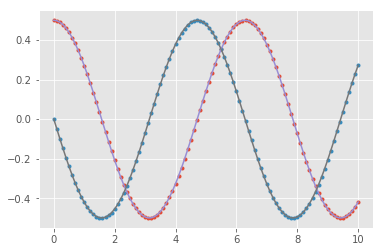

In [25]:
def ode_rkexplicit(f, u0, butcher=None, tfinal=1, h=.1):
    if butcher is None:
        A, b = rk_butcher_4()
    else:
        A, b = butcher
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        u += h * fY.dot(b)
        t = tnext
        hist.append((t, u.copy()))
    return hist

test = linear(numpy.array([[0, 1],[-1, 0]]))
u0 = numpy.array([.5, 0])
hist = ode_rkexplicit(test.f, u0, rk_butcher_4(), tfinal=10, h=.1)
times = [t for t,u in hist]
pyplot.plot(times, [u for t,u in hist], '.')
pyplot.plot(times, test.u(times, u0));

#### Observations
* Solutions look pretty good and we didn't need a solve.
* We needed to evaluate the right hand side $s$ times per step

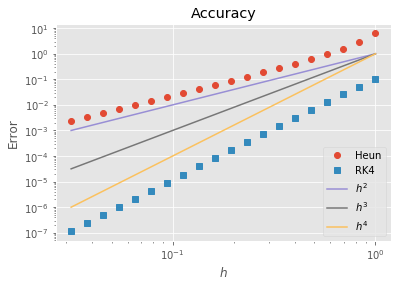

In [26]:
def mms_error(h, rk_butcher):
    hist = ode_rkexplicit(test.f, u0, rk_butcher(), tfinal=20, h=h)
    times = [t for t,u in hist]
    u = numpy.array([u for t,u in hist])
    return numpy.linalg.norm(u - test.u(times, u0), numpy.inf)

hs = numpy.logspace(-1.5, 0, 20)
error_heun = [mms_error(h, rk_butcher_heun) for h in hs]
error_rk4 = [mms_error(h, rk_butcher_4) for h in hs]
pyplot.loglog(hs, error_heun, 'o', label='Heun')
pyplot.loglog(hs, error_rk4, 's', label='RK4')
for p in [2,3,4]:
    pyplot.loglog(hs, hs**p, label='$h^%d$'%p)
pyplot.title('Accuracy')
pyplot.legend(loc='lower right')
pyplot.ylabel('Error')
pyplot.xlabel('$h$');

## Work-precision diagrams for comparing methods

Since these methods do not cost the same per step, it is more enlightening to compare them using some measure of cost.  For large systems of ODE, such as arise by discretizing a PDE, the cost of time integration is dominated by evaluating the right hand side (discrete spatial operator) on each stage.  Measuring CPU time is a more holistic measure of cost, but the results depend on the implementation, computer, and possible operating system interference/variability.  Counting right hand side function evaluations is a convenient, reproducible measure of cost.

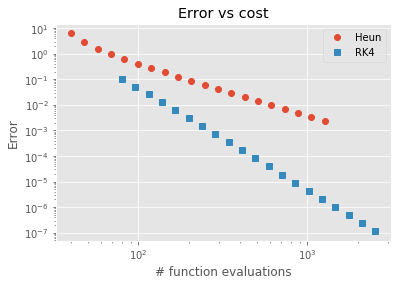

In [27]:
pyplot.loglog(20*2/hs, error_heun, 'o', label='Heun')
pyplot.loglog(20*4/hs, error_rk4, 's', label='RK4')
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='upper right');

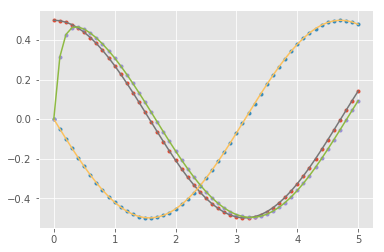

In [28]:
test = linear(numpy.array([[0, 1, 0],[-1, 0, 0],[10, 0, -10]]))
u0 = numpy.array([.5, 0, 0])
hist = ode_rkexplicit(test.f, u0, rk_butcher_4(), tfinal=5, h=.1)
times = [t for t,u in hist]
pyplot.plot(times, [u for t,u in hist], '.')
pyplot.plot(times, test.u(times, u0));

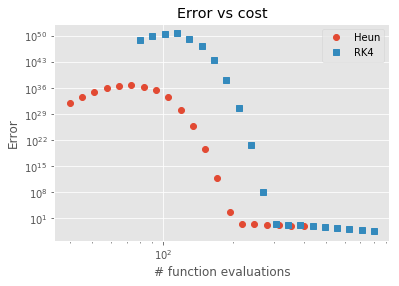

In [29]:
hs = numpy.logspace(-1, 0, 20)
error_heun = [mms_error(h, rk_butcher_heun) for h in hs]
error_rk4 = [mms_error(h, rk_butcher_4) for h in hs]
pyplot.loglog(20*2/hs, error_heun, 'o', label='Heun')
pyplot.loglog(20*4/hs, error_rk4, 's', label='RK4')
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='upper right');

Evidently Heun becomes resolved at lower cost than RK4.

## Refinement in space and time

When solving a transient PDE, we need to balance spatial discretization error with temporal discretization error.  Let's consider the advection equation.

In [72]:
A = numpy.array([[1,-1,0,0],[-1,2,1,0],[0,-1,2,1],[0,0,-1,1]])

In [77]:
A = numpy.array([[1,-1,0,0],[-1,2,1,0],[0,-1,2,1],[0,0,-1,1]])
print(A)
numpy.linalg.matrix_rank(A)

[[ 1 -1  0  0]
 [-1  2  1  0]
 [ 0 -1  2  1]
 [ 0  0 -1  1]]


4